In [2]:
import numpy as np
import pandas as pd
import pickle
import plotnine as p9
from vbayesfa.lpa_outcome_analysis import fit_y_normal, fit_y_bernoulli
from vbayesfa.lpa import lpa_model
from vbayesfa.fit_lpa import fit_lpa

%matplotlib inline
data_set = '0 missing'#'<= 2 missing'#
plot_path = '/Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/'

In [3]:
# load fitted LPA model

path = '/Users/sampaskewitz/Documents/ABCD model fitting/DPM-LPA fitting/'
if data_set == '<= 2 missing':
    file = open(path + '10-06-2023 (best infinite LPA model, full data set).pkl', "rb")
    #file = open(path + '10-04-2023 (best infinite LPA model, stronger prior on alpha = 1).pkl', "rb")
elif data_set == '0 missing':
    file = open(path + '10-10-2023 (best infinite LPA model, no missing data).pkl', "rb")

model = pickle.load(file)
model._update_hard_assignment()
file.close()

# data

path = '/Users/sampaskewitz/Documents/ABCD data processing/complete data sets (z-scored etc)/'

x = pd.read_csv(path + 'task behavioral data (2-year z-scored full data).csv',
                index_col = 0).loc[model.index]
y_cont = pd.read_csv(path + 'outcome data (2-year z-scored full data).csv',
                     index_col = 0).loc[model.index]
y_cont.drop(['extern_youth', 'intern_youth', 'atten_youth', 'with_dep', 'anx_dep', 'somatic', 'alc_pos_expect', 'alc_neg_expect'],
             axis = 1,
             inplace = True)
y_binary = pd.read_csv(path + 'outcome data (2-year binary vars full data).csv',
                       index_col = 0).loc[model.index, ['any_substance_use', 'conduct_disorder']]
y_cont_3year = pd.read_csv(path + 'outcome data (3-year z-scored full data).csv',index_col = 0).loc[model.index]
y_cont_3year.drop(['extern_youth', 'intern_youth', 'atten_youth', 'neg_urg', 'pos_urg', 'with_dep', 'anx_dep', 'somatic', 'alc_pos_expect', 'alc_neg_expect'],
                  axis = 1,
                  inplace = True)
y_binary_3year = pd.read_csv(path + 'outcome data (3-year binary vars full data).csv',
                             index_col = 0).loc[model.index, ['any_substance_use', 'conduct_disorder']]
info = pd.read_csv('/Users/sampaskewitz/Documents/ABCD data processing/processed data (release 5.0)/ABCD 2-year demographic info etc.csv',
                   index_col = 0).loc[model.index]


# nice names for data variables
nice_x_names = {'little_man': 'spatial processing',
                'ravlt': 'auditory memory',
                'dice': 'risk-taking',
                'reading': 'reading decoding',
                'picture': 'visual-spatial memory',
                'pattern': 'processing speed',
                'flanker': 'attentional control',
                'picvocab': 'vocabulary',
                'neg_ssrt': 'response inhibition',
                'recog_dprime': 'recognition memory',
                'two_back': 'working memory'}

nice_y_names = {'neg_urg': 'negative urgency',
                'pos_urg': 'positive urgency',
                'intern': 'internalizing',
                'agrs': 'aggression',
                'rbreak': 'rule breaking',
                'extern': 'externalizing'}

# rename columns
x = x.rename(columns = nice_x_names)
y_cont = y_cont.rename(columns = nice_y_names)
y_cont.columns = pd.Categorical(y_cont.columns, 
                                categories = ['externalizing', 'rule breaking', 'aggression', 'positive urgency', 'negative urgency', 'internalizing'],
                                ordered = True)
y_cont_3year = y_cont_3year.rename(columns = nice_y_names)
y_cont_3year.columns = pd.Categorical(y_cont_3year.columns, 
                                      categories = ['externalizing', 'rule breaking', 'aggression', 'internalizing'],
                                      ordered = True)
model.x_names = pd.Series(nice_x_names)[model.x_names].values
model.x_names = pd.Categorical(model.x_names, categories = model.x_names, ordered = True)

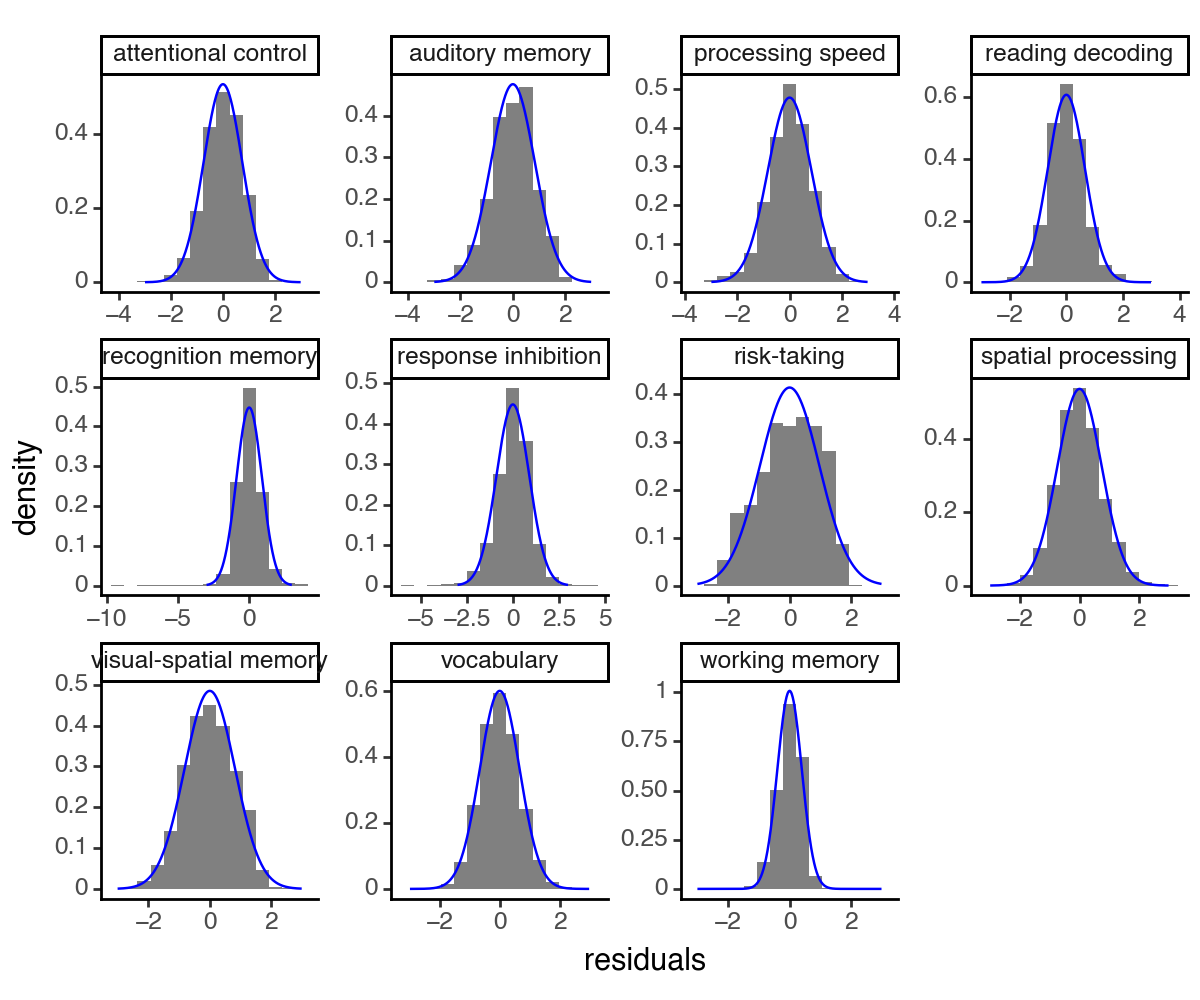

<Figure Size: (600 x 500)>

In [6]:
# residual plots
model.plot_residuals(bins = 15)

In [7]:
# demographic data
print(np.round(100*info['sex'].value_counts()/model.n, 1))
print()
print(np.round(100*info['race_ethnicity'].value_counts()/model.n, 1))

sex
Male      52.1
Female    47.9
Name: count, dtype: float64

race_ethnicity
White       57.9
Hispanic    18.9
Black       11.0
Other       10.2
Asian        1.9
Name: count, dtype: float64


In [8]:
def cor_plot(data, figure_size = [5, 3], font_size = 8, title = None):
    '''
    Convenience function for drawing a correlation matrix heatmap.
    '''
    cor_matrix = np.round(data.corr(), 2)
    cor_matrix = cor_matrix.stack().reset_index()
    cor_matrix.columns = ['variable 1', 'variable 2', 'r']
    cor_matrix['variable 1'] = pd.Categorical(cor_matrix['variable 1'], categories = data.columns.values, ordered = True) # don't change the order of variables
    cor_matrix['variable 2'] = pd.Categorical(cor_matrix['variable 2'], categories = data.columns.values, ordered = True) # don't change the order of variables
    cor_matrix
    
    plot = (p9.ggplot(cor_matrix, p9.aes('variable 1', 'variable 2', fill = 'r'))
            + p9.geom_tile(p9.aes(width=1.2, height=1.2))
            + p9.geom_text(p9.aes(label='r'), size=font_size-2)
            + p9.theme_classic(base_size = font_size)
            + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1),
                       figure_size = figure_size,
                       legend_position = 'none')
            + p9.scale_fill_gradient2(low='#FAD0C3', mid='white', high='#8ed1fc', midpoint=0, limits=[-1,1])
            + p9.xlab('') + p9.ylab('')
)
    if not title is None:
        plot += p9.ggtitle(title)
    return plot

/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 5 in image.
/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/correlation between all variables


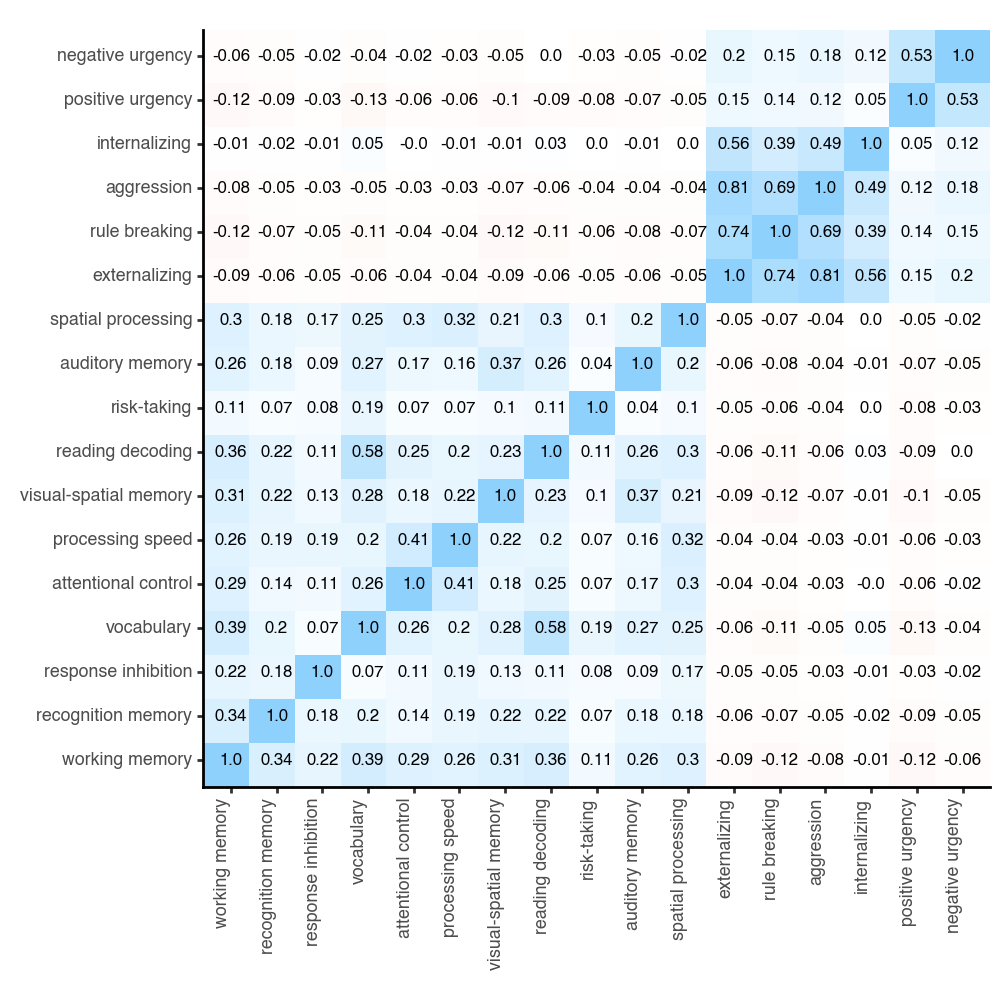

<Figure Size: (500 x 500)>

In [9]:
xy_cor_plot = cor_plot(pd.concat([x, y_cont], axis = 1), figure_size = [5, 5], font_size = 8)
xy_cor_plot.save(plot_path + 'correlation between all variables', dpi = 300)
xy_cor_plot

In [10]:
print('sample sizes for continuous outcome variables (y)\n')
print(('\n two year followup\n'))
print((1 - y_cont.isna()).sum(axis = 0))
print(('\n three year followup\n'))
print((1 - y_cont_3year.isna()).sum(axis = 0))

sample sizes for continuous outcome variables (y)


 two year followup

externalizing       4977
rule breaking       4977
aggression          4977
internalizing       4977
positive urgency    5230
negative urgency    5230
dtype: int64

 three year followup

externalizing    4742
rule breaking    4742
aggression       4742
internalizing    4742
dtype: int64


In [11]:
model.compute_E_log_lik()

-68226.20184975772

In [13]:
model.print_summary(start_profile_labels_from1 = True)

n = 5232

M-Plus style entropy statistic: 0.84
(= 1 - entropy of z/max entropy of z)

number of non-empty profiles: 9

pi (profile probabilties): 
  profile 1  profile 2  profile 3  profile 4  profile 5  profile 6  profile 7  \
       0.58       0.12        0.1       0.09       0.05       0.03       0.02   

  profile 8  profile 9  
       0.01       0.01  

number in each profile: 
  profile 1  profile 2  profile 3  profile 4  profile 5  profile 6  profile 7  \
       3018        616        531        457        243        162         88   

  profile 8  profile 9  
         74         43  

alpha (concentration parameter): 13.49

mu: (means)
                       profile 1  profile 2  profile 3  profile 4  profile 5  \
working memory              0.30       0.70      -0.45       0.66      -1.11   
recognition memory          0.04       0.69      -0.35       0.50      -0.69   
response inhibition        -0.00       0.43       0.04       0.19      -1.24   
vocabulary                  

In [5]:
model.z_hat + 1

array([1, 8, 2, ..., 5, 1, 2])

In [15]:
# For export to R for analysis with the Bayes factor package there (as an alternative to my home-grown fractional Bayes factors).

export = False
if export:
    def compute_partition_df(z, index):
        n = z.shape[1] # number of observations
        n_t_overall = z.shape[0] # number of groups
        partition_list = list(partition(list(range(n_t_overall)))) # list of all partitions
        partition_list.pop(0) # remove the initial partition, which has everyone in the same group (H0)
        n_partitions = len(partition_list)
        df = pd.DataFrame(0.0, columns = ['partition_' + str(p + 1) for p in range(n_partitions)], index = index)
        partition_def_str = []
        z_flat = z.argmax(axis = 0)
        
        for p in range(n_partitions):
            prt = partition_list[p] # current partition
            partition_size = len(prt) # number of groups in the partition
            for t in range(partition_size):
                df.loc[np.isin(z_flat, prt[t]), 'partition_' + str(p + 1)] = t
            partition_def_str += [str(prt)]
        
        return df, pd.Series(partition_def_str, index = ['partition_' + str(p + 1) for p in range(n_partitions)])
    
    (partition_df, partition_def_str) = compute_partition_df(model.z_hat_1hot, model.index)

    partition_def_str.to_csv('partition_definitions.csv')

    hard_2year = pd.concat([y_cont, partition_df], axis = 1)
    hard_2year.to_csv('for_hard_analysis_2year (' + data_set + ').csv')

    hard_3year = pd.concat([y_cont_3year, partition_df], axis = 1)
    hard_3year.to_csv('for_hard_analysis_3year (' + data_set + ').csv')

In [9]:
hard_2year = y_cont.copy()
hard_2year['z_hat'] = model.z_hat + 1
hard_2year.to_csv('for_hard_analysis_2year (' + data_set + ').csv')

hard_3year = y_cont_3year.copy()
hard_3year['z_hat'] = model.z_hat + 1
hard_3year.to_csv('for_hard_analysis_3year (' + data_set + ').csv')

In [7]:
hard_2year

,externalizing,rule breaking,aggression,internalizing,positive urgency,negative urgency,z_hat
NDAR_INV00CY2MDM,2.502298,1.893051,4.563022,0.974156,0.220005,0.088474,1
NDAR_INV00U4FTRU,NaN,NaN,NaN,NaN,1.716709,1.366079,8
NDAR_INV00X2TBWJ,-0.048986,-0.266427,-0.477988,0.211738,-0.154171,0.088474,2
NDAR_INV010ZM3H9,0.665373,-0.506369,0.530214,0.592947,-1.276699,-0.763262,5
NDAR_INV014RTM1V,-1.171551,-0.506369,-0.477988,-0.645982,-0.154171,-1.189130,1
...,...,...,...,...,...,...,...
NDAR_INVZZ6ZJ2KY,0.971527,-0.266427,0.731854,-0.455378,2.465061,0.514343,1
NDAR_INVZZ81LEEV,-1.171551,-0.506369,-0.477988,-0.264773,-0.528347,0.514343,1
NDAR_INVZZLZCKAY,0.971527,0.693341,0.328573,1.831877,0.594181,1.366079,5
NDAR_INVZZPKBDAC,-1.069500,-0.506369,-0.477988,-0.836587,-1.276699,-1.189130,1


In [17]:
#model.print_univariate_entropy_stats()

/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 8 in image.
/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/profile_means


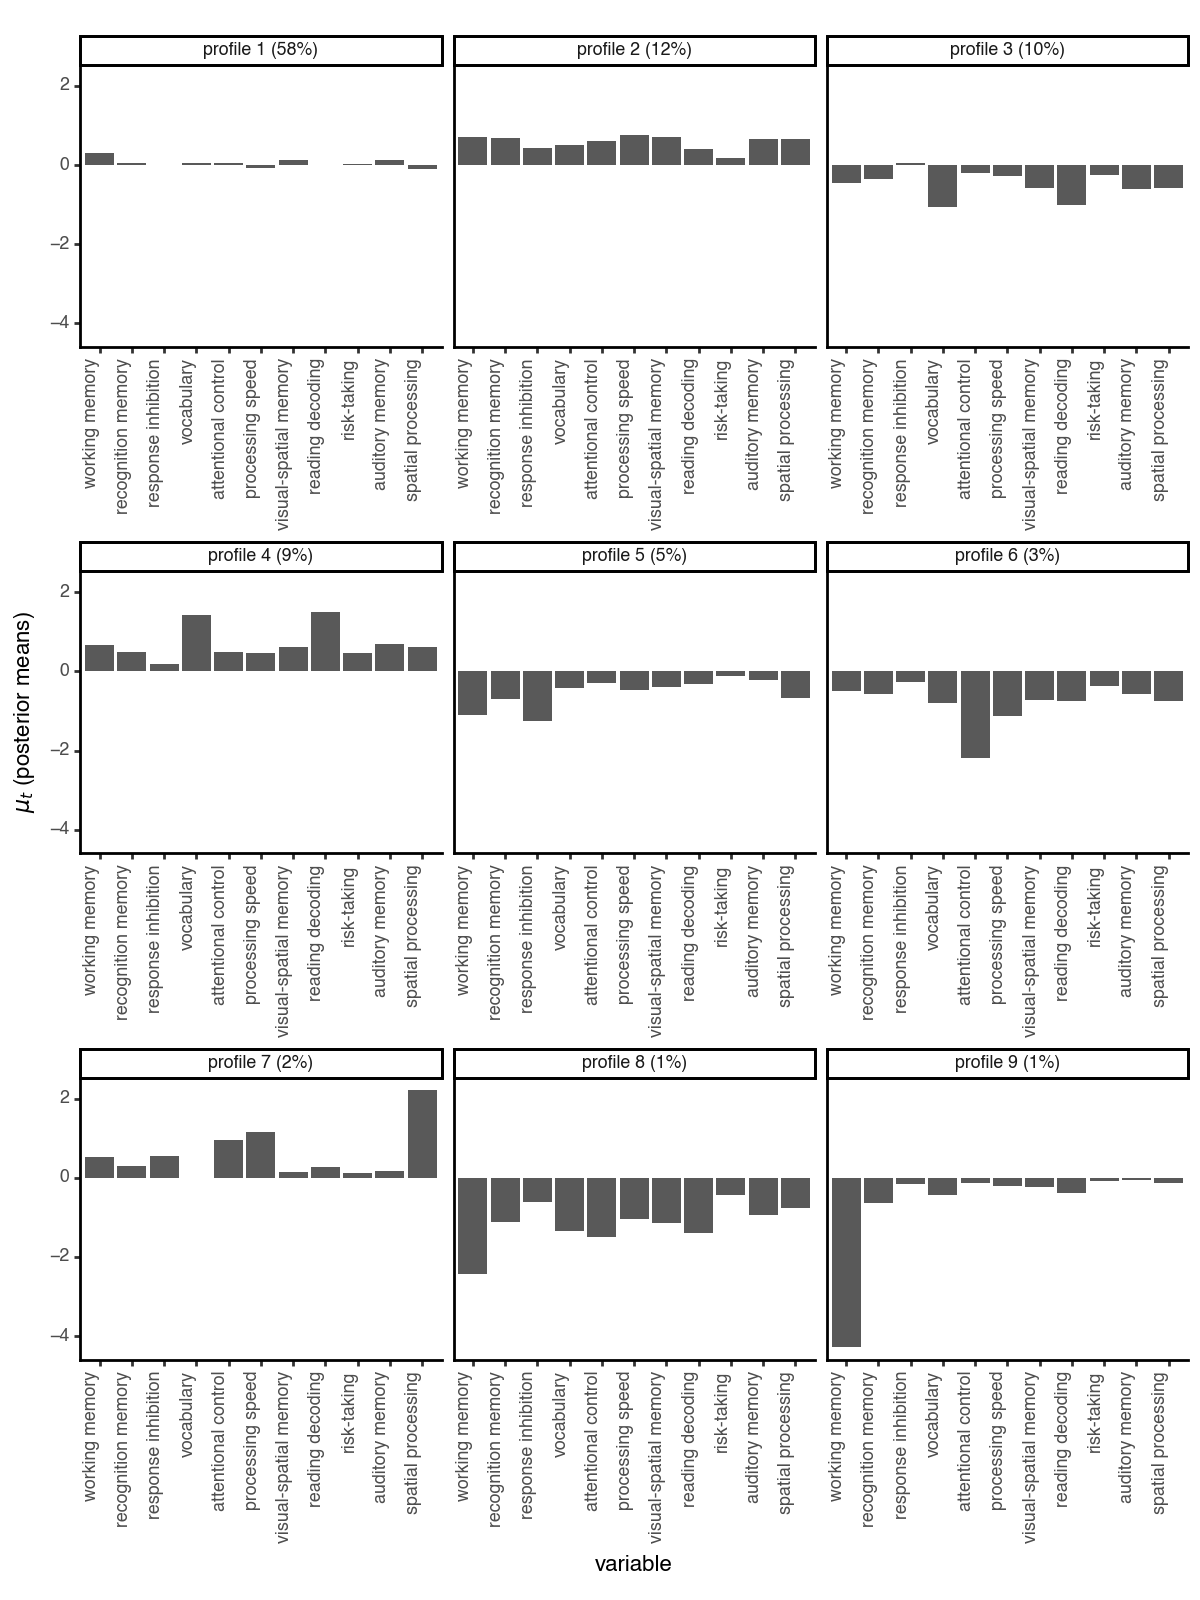

<Figure Size: (600 x 800)>

In [18]:
profile_plot = model.plot_profile_means(figure_size = [6, 8],
                                        ncol = 3,
                                        font_size = 8,
                                        start_profile_labels_from1 = True,
                                        facet_var = 'profile')

profile_plot += p9.ylab('$\\mu_t$ (posterior means)')
profile_plot.save(plot_path + 'profile_means', dpi = 300)
profile_plot

[[1.   0.07 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.07 1.   0.   0.12 0.   0.   0.06 0.   0.  ]
 [0.01 0.   1.   0.   0.05 0.02 0.   0.   0.  ]
 [0.   0.12 0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.05 0.   1.   0.01 0.   0.   0.  ]
 [0.   0.   0.02 0.   0.01 1.   0.   0.   0.  ]
 [0.   0.06 0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]
max similarity: 0.11851776
mean similarity: 0.00928003
min distance: 2.06528082
mean distance: 5.98958423


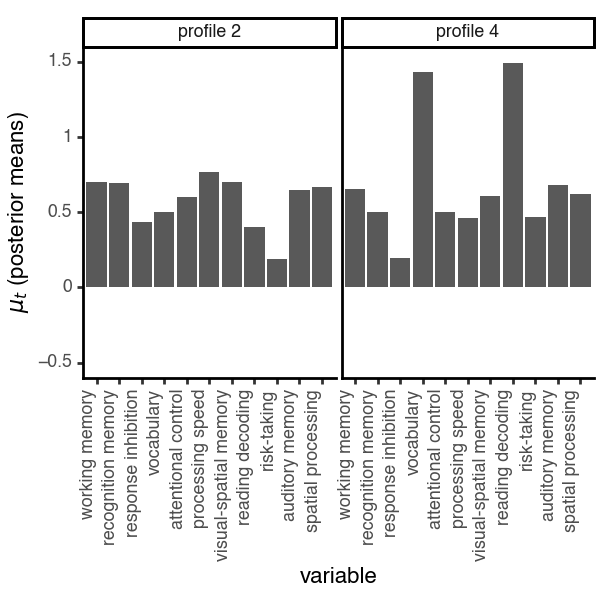

<Figure Size: (300 x 300)>

In [19]:
sim = model.profile_similarity(figure_size = [3, 3], font_size = 8, start_profile_labels_from1 = True)
print(np.round(sim['similarity'], 2))
print('max similarity: ' + str(np.round(sim['max_similarity'], 8)))
print('mean similarity: ' + str(np.round(sim['mean_similarity'], 8)))
print('min distance: ' + str(np.round(sim['min_distance'], 8)))
print('mean distance: ' + str(np.round(sim['mean_distance'], 8)))
sim_plot = sim['plot']
sim_plot += p9.scales.ylim([-0.5, 1.5])
sim_plot += p9.ylab('$\\mu_t$ (posterior means)')
#sim_plot.save(plot_path + 'DPMLPA most similar profiles (' + data_set + ')', dpi = 300)
sim_plot

In [20]:
cont_2year = fit_y_normal(model = model,
                          y = y_cont,
                          facet_var = 'variable',
                          #profile_labels = profile_labels,
                          figure_size = [10, 8],
                          start_profile_labels_from1 = True,
                          ncol = 4)

print('\nR^2\n')
print(np.round(cont_2year['r2'], 4))


R^2

externalizing       0.0090
rule breaking       0.0167
aggression          0.0070
internalizing       0.0037
positive urgency    0.0230
negative urgency    0.0052
dtype: float64


In [22]:
cont_3year = fit_y_normal(model = model,
                          y = y_cont_3year,
                          facet_var = 'variable',
                          #profile_labels = profile_labels,
                          figure_size = [10, 8],
                          start_profile_labels_from1 = True,
                          ncol = 4)
print('\nR^2\n')
print(np.round(cont_3year['r2'], 4))


R^2

externalizing    0.0079
rule breaking    0.0140
aggression       0.0049
internalizing    0.0048
dtype: float64


/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 4 in image.
/Users/sampaskewitz/miniconda3/envs/abcd/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/sampaskewitz/Dropbox/SamP-Arielle/ABCD Fingerprint/figures for paper/continuous outcomes (combined)


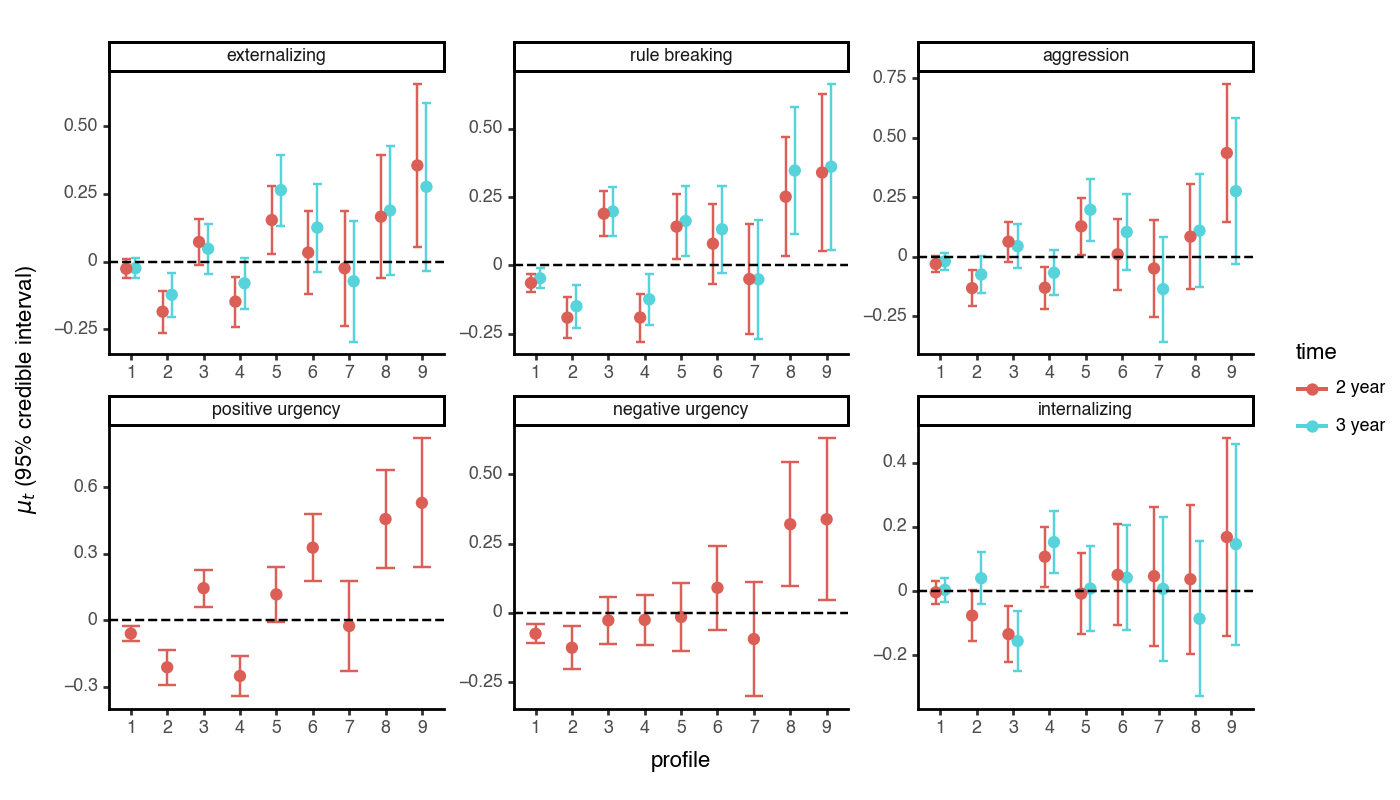

<Figure Size: (700 x 400)>

In [23]:
# CREATE COMBINED 2-YEAR AND 3-YEAR OUTCOME PLOT (CONT VARIABLES)
cont_2year['plot_df']['time'] = '2 year'
cont_3year['plot_df']['time'] = '3 year'
combo_cont_plot_df = pd.concat([cont_2year['plot_df'], cont_3year['plot_df']])
vars_to_keep = ['externalizing', 'rule breaking', 'aggression', 'positive urgency', 'negative urgency', 'internalizing', ]
combo_cont_plot_df = combo_cont_plot_df.loc[combo_cont_plot_df['variable'].isin(vars_to_keep), :]
combo_cont_plot_df['variable'] = pd.Categorical(combo_cont_plot_df['variable'],
                                                categories = vars_to_keep,
                                                ordered = True)

plot = p9.ggplot(combo_cont_plot_df, p9.aes(color = 'time', x = 'profile', y = 'mu', ymin = 'mu_minus', ymax = 'mu_plus'))
plot += p9.geom_point(position = p9.position_dodge(0.5))
plot += p9.geom_errorbar(position = p9.position_dodge(0.5))
plot += p9.geom_hline(yintercept = 0, linetype = 'dashed')
plot += p9.theme_classic(base_size = 8)
plot += p9.theme(figure_size = [7, 4])
plot += p9.ylab('$\\mu_t$ (95% credible interval)')
plot += p9.facet_wrap('variable', scales = 'free', ncol = 3)
#plot += p9.ggtitle('2 year vs. 3 year follow-up, profile means')
plot.save(plot_path + 'continuous outcomes (combined)', dpi = 300)
plot